## **Define the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip install -q keras

# **Define the Path of Train,Test and Validation Data**

In [ ]:
train_path='/content/drive/MyDrive/Colab Notebooks/X-ray_Images/train'
test_path='/content/drive/MyDrive/Colab Notebooks/X-ray_Images/test'
val_path='/content/drive/MyDrive/Colab Notebooks/X-ray_Images/val'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
labels=['PNEUMONIA','NORMAL']
img_size=150
def get_data(data_dir):
  data=[]
  for label in labels:
    path=os.path.join(data_dir,label)
    class_num=labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        resized_arr=cv2.resize(img_arr,(img_size,img_size))
        data.append([resized_arr,class_num])
      except Exception as e:
        print(e)
  return np.array(data)
    

In [ ]:
train=get_data(train_path)
test=get_data(test_path)
val=get_data(val_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


# **Exploratory Data Analysis (EDA)**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Countplot of Affected Vs Normal')

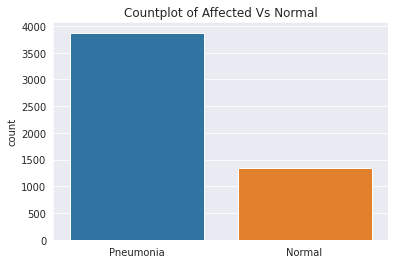

In [ ]:
l = []
for i in train:
    if(i[1]==0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 
plt.title('Countplot of Affected Vs Normal')

Here We can see that the number of people affected with Pneumonia is more than the Normal people.So the dataset is imbalanced

In [ ]:
pneumonia_dir='/content/drive/MyDrive/Colab Notebooks/X-ray_Images/train/PNEUMONIA'
pneumonia=os.listdir(pneumonia_dir)

**Plotting X_Ray Images of Pneumonia**

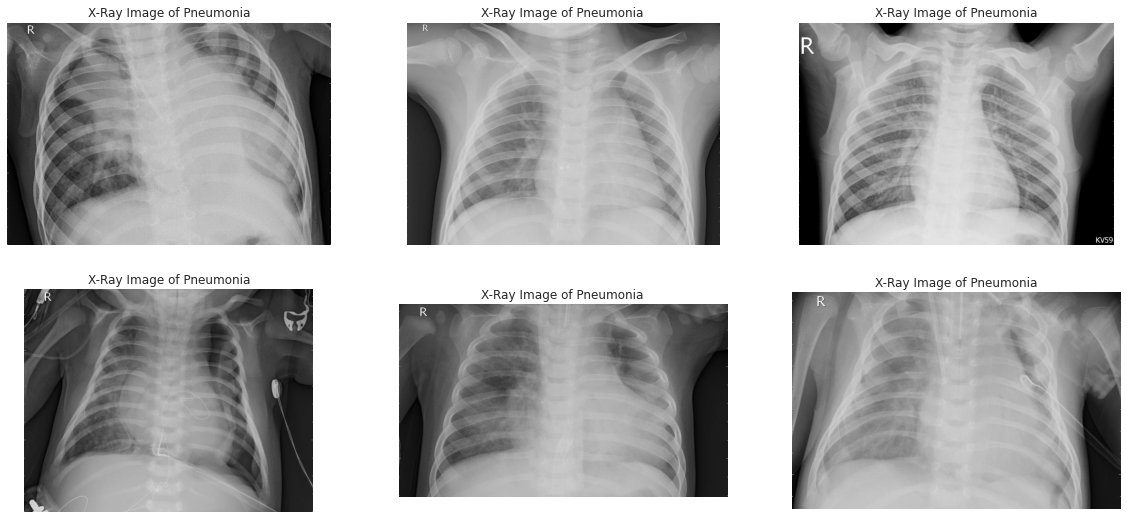

In [ ]:
plt.figure(figsize=(20,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  img=plt.imread(os.path.join(pneumonia_dir,pneumonia[i]))
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.title('X-Ray Image of Pneumonia')
  


In [ ]:
Normal_dir='/content/drive/MyDrive/Colab Notebooks/X-ray_Images/train/NORMAL'
Normal=os.listdir(Normal_dir)

**Plotting X_Ray Image of Normal**

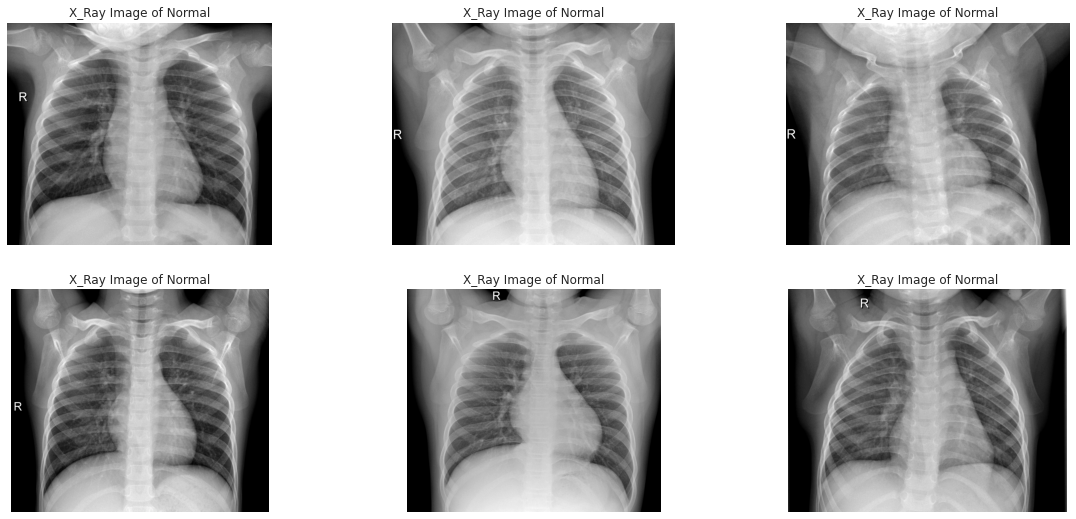

In [ ]:
plt.figure(figsize=(20,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  img=plt.imread(os.path.join(Normal_dir,Normal[i]))
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.title('X_Ray Image of Normal')

In [ ]:
x_train=[]
y_train=[]

x_test=[]
y_test=[]

x_val=[]
y_val=[]

for feature,label in train:
  x_train.append(feature)
  y_train.append(label)

for feature,label in test:
  x_test.append(feature)
  y_test.append(label)

for feature,label in val:
  x_val.append(feature)
  y_val.append(label)

**Normalizing the Data**

In [ ]:
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255
x_val=np.array(x_val)/255

**Reshaping the Dataset**

In [ ]:
x_train=x_train.reshape(-1,150,150,1)
x_test=x_test.reshape(-1,150,150,3)

y_train=np.array(y_train)
y_test=np.array(y_test)

y_val=np.array(y_val)

**Data Augmentation**

From the Countplot we have clearly seen that this is a imbalance dataset, so to prevent overfitting Data Augmentation is required.

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.2,
    zca_whitening=False,
    horizontal_flip=True,
    fill_mode='nearest',
    shear_range=0.2,
    featurewise_center=False
)
train_generator=train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/X-ray_Images/train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)
val_datagen=ImageDataGenerator(rescale=1/255)
val_generator=val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/X-ray_Images/test',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Model Building**

In [ ]:
model=tf.keras.Sequential([
                           tf.keras.layers.Conv2D(32,(3,3),strides=1,padding='same',activation='relu',input_shape=(150,150,3)),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.MaxPool2D((2,2),strides=2,padding='same'),
                           tf.keras.layers.Conv2D(64,(3,3),strides=1,padding='same',activation='relu'),
                           tf.keras.layers.Dropout(0.1),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.MaxPool2D((2,2),strides=2,padding='same'),
                           tf.keras.layers.Conv2D(64,(3,3),activation='relu',strides=1,padding='same'),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.MaxPool2D((2,2),padding='same',strides=2),
                           tf.keras.layers.Conv2D(128,(3,3),strides=1,padding='same',activation='relu'),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.MaxPool2D((2,2),padding='same',strides=2),
                           tf.keras.layers.Conv2D(256,(3,3),strides=1,padding='same',activation='relu'),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.MaxPool2D((2,2),padding='same',strides=2),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_40 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_32 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_41 (Bat  (None, 75, 75, 64)      

In [ ]:
history=model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15
163/163 [==============================] - 86s 524ms/step - loss: 0.2175 - accuracy: 0.9264 - val_loss: 81.8751 - val_accuracy: 0.5000
Epoch 2/15
163/163 [==============================] - 85s 520ms/step - loss: 0.2065 - accuracy: 0.9296 - val_loss: 119.9978 - val_accuracy: 0.6875
Epoch 3/15
163/163 [==============================] - 84s 517ms/step - loss: 0.1886 - accuracy: 0.9331 - val_loss: 69.9913 - val_accuracy: 0.5312
Epoch 4/15
163/163 [==============================] - 84s 516ms/step - loss: 0.1801 - accuracy: 0.9375 - val_loss: 0.5300 - val_accuracy: 0.8750
Epoch 5/15
163/163 [==============================] - 86s 528ms/step - loss: 0.1953 - accuracy: 0.9379 - val_loss: 59.9215 - val_accuracy: 0.5312
Epoch 6/15
163/163 [==============================] - 86s 524ms/step - loss: 0.1699 - accuracy: 0.9423 - val_loss: 1.2098 - val_accuracy: 0.6875
Epoch 7/15
163/163 [==============================] - 86s 528ms/step - loss: 0.1640 - accuracy: 0.9433 - val_loss: 0.6615 - v

In [ ]:

print('Loss of the model is: ',model.evaluate(val_generator)[0])
print('Accuracy of the model is: ',model.evaluate(val_generator)[1]*100,'%')

20/20 [==============================] - 7s 323ms/step - loss: 0.4230 - accuracy: 0.8814
Loss of the model is:  0.4230426251888275
20/20 [==============================] - 7s 338ms/step - loss: 0.4230 - accuracy: 0.8814
Accuracy of the model is:  88.14102411270142 %


**Plotting Accuracy and Loss with Epochs for Training and Validation Data**

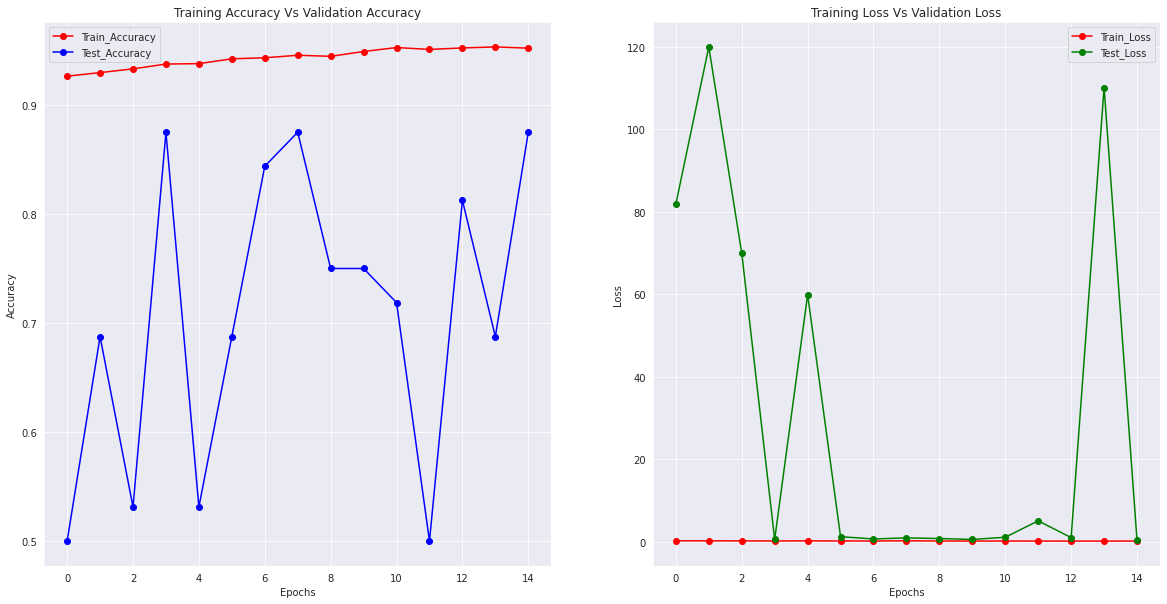

In [ ]:
epochs=[i for i in range(15)]
fig,ax=plt.subplots(1,2)
train_acc=history.history['accuracy']
train_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs,train_acc,'ro-',label='Train_Accuracy')
ax[0].plot(epochs,val_acc,'bo-',label='Test_Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy Vs Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs,train_loss,'ro-',label='Train_Loss')
ax[1].plot(epochs,val_loss,'go-',label='Test_Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training Loss Vs Validation Loss')
ax[1].legend()